# hurricane-net
Hammad Usmani
### A machine learning algorithm to forecast the intensity and trajectory of Atlantic tropical storms
[https://github.com/hammad93/hurricane-net](https://github.com/hammad93/hurricane-net)

### Table of Contents

1. [Background](#Background)
2. [Problem](#Problem)
3. [Datasets](#Datasets)
4. [Workflow Diagram](#Workflow)
5. [Data Extraction](#Extract)
6. [Data Transformation](#Transform)
7. [Data Loading](#Load)
8. [Feature Engineering](#FeatureEngineering)
9. [Model Architecture](#ModelArchitecture)
11. [Model Selection](#ModelSelection)
12. [Paramater Optimization](#Optimization)
13. [Model Evaluation & Benchmarks](#Benchmarks)
14. [Visualizations](#Visualizations)

![Hurricane Maria 2017](img/hurricane-maria.png "Hurricane Maria. Source: NOAA")

## Background<a id="Background"></a>

The National Hurricane Center (NHC) and National Oceanic and Atmospheric Administration (NOAA) provide predictions for storms trajectories, intensity, and size. They create these predictions based on models that can be classified into 3 groups: dynamical, statistical, and ensemble [1]. The most accurate models are based on computational fluid dynamics and achieve more precision than their statistical and ensemble counterparts [1][4]. The current statistical models (OCD5) are based on multiple regression methods that can explain a significant amount of variance [1]. In this project, we research and implement the domain of machine learning and deep learning into predictive hurricane models for both trajectory and intensity and evaluate them against the NHC standards. 
Previous research into machine learning to forecast tropical Atlantic storms include a sparse recurrent neural network (Kordmahalleh, Sefidmazgi, & Homaifar, 2016) and an artificial neural network (Jung & Das, 2013); both achieved favorable results. The hurricane models created can be utilized to develop more precise emergency planning. There is a necessity for more accurate and timely models that can help reduce the amount of loss caused by hurricanes. 

## Problem<a id="Problem"></a>

The NOAA and NHC have several different classifications for Atlantic hurricane models that describe feature prediction and model architecture. The 3 main classifications for hurricane model architecture include dynamical, statistical, and ensemble. Classifications also include relative compute time required to create an output grouped as either early or late and forecast parameters such as trajectory, intensity, and wind radii. The most accurate models are late models that take upwards of 6 hours to produce an output whereas models that can produce an output in seconds to minutes are called early. Early models tend to be statistical which include the baseline model for trajectory named CLIPER5 Climatology and Persistence (CLP5) utilizing multivariate regression. The performance for these methods can be augmented by incorporating more advanced statistical methods from deep learning such as recurrent neural networks. Kordmahalleh et al., 2016 created a sparse recurrent neural network augmented by a genetic algorithm but there are factors requiring improvement. The training set utilized an older version of the NHC Hurricane Database format known as HURDAT while a new format has been released called HURDAT2 with additional information on wind radii. Kordmahalleh et al., 2016 also utilized benchmarks different from the standard applied within the NHC. Other than improving their methodology, we can expand the scope by creating separate models for both intensity and trajectory. These models can be used to predict the trajectory and intensity for future Atlantic storms.

## Datasets<a id="Datasets"></a>

The following datasets and inputs including their sources will be used to create machine learning models:
- NHC Hurricane Database (HURDAT2)
    - http://www.nhc.noaa.gov/data/#hurdat
    - https://www.kaggle.com/noaa/hurricane-database
- NHC Forecast Error Database
    - http://www.nhc.noaa.gov/verification/verify7.shtml
- NHC GIS
    - http://www.nhc.noaa.gov/gis/
    
The NHC HURDAT2 database contains the tracking information for Atlantic tropical and subtropical cyclones which includes hurricanes and tropical storms from 1851 to 2016. The most updated version of the dataset is included on the noaa.gov site and includes 2 additional years of cyclone data compared to the data set available on Kaggle and is potentially more descriptive. To match the inputs of the baseline model used by the NHC, we are calculating the forward motion of the storm by applying a vector based on previous and current geographical location.

*Table 1. This table contains the tentative features as input to the model*

| **Name**         | **Data Type** | **Description**                                                     |
|------------------|---------------|---------------------------------------------------------------------|
| Time             | Date Time     | The date and time of the measurement.                               |
| Latitude         | Float         | The geographical latitude of the storm eye to 1 decimal precision.  |
| Longitude        | Float         | The geographical longitude of the storm eye to 1 decimal precision. |
| Maximum Winds    | Integer       | The maximum sustained winds within the storm.                       |
| Minimum Pressure | Integer       | The minimum barometric pressure within the storm.                   |
| Forward Motion   | String        | Calculated vector of motion based on location in time series.       |

The Forecast Error Database contains information on the accuracy of predicted models from the NHC. The two model forecast errors available are labeled OFCL and BCD5. The OFCL is the official NHC forecast and the BCD5 is the real track available. This data set can be used to benchmark and evaluate the deep learning model. 
The NOAA and NHC also hosts a geographical information system (GIS) that contains raw and processed data on hurricanes. The server hosting the GIS is publicly accessible and can be used to evaluate our model by comparing the 2017 Atlantic tropical season. The preliminary best tracks can be found here before they are finalized and available in the HURDAT2 data set. With the GIS, we can construct a final evaluation data set.

*Diagram 1. This graphic describes the workflow for the deep learning models*.<a id="Workflow"></a>
![Data Pipeline](img/Deep Learning Workflow.png "hurricane-net Data Pipeline")

## Extract Data<a id="Extract"></a>

*The following code uses the hurdat2 and models modules created to provide a class interface for the HURDAT2 and error forecast database located in the data and models folder. *

We will begin our steps to perform extraction, transformation, and loading of our data for analysis or broadly known as ETL. Although we're dividing these steps into disctinct procedures, they are often more fluid and often have overlaps. The extraction phase consists of collecting and parsing the HURDAT2 and error forecast databases for analysis and benchmarking. The HURDAT2 database is our core foundation for creating the deep learning model. We store the database in its raw .txt format but it can be directly linked to the database hosted by the NHC.

In [1]:
# Import various libraries throughout the software
from pprint import pprint
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Import from hurdat2 class in data folder and models class from hurricane-models folder
from data.hurdat2 import hurdat2
from errors.models import models

# Initialize Dataframe for hurricanes and error database
dataset = hurdat2("data/hurdat2.txt")
errors = models("errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt")

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.hurricanes.query('storm_id == "AL122005"').head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44063,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44064,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44065,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44066,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44067,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(errors.models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): 0.0,
                                      datetime.datetime(2005, 8, 29, 6, 0): 20.9,
                                      datetime.datetime(2005, 8, 29, 18, 0): 93.6,
                                      datetime.datetime(2005, 8, 30, 6, 0): 170.2,
                                      datetime.datetime(2005, 8, 30, 18, 0): None,
                                      datetime.datetime(2005, 8, 31, 18, 0): None,
                                      datetime.datetime(2005, 9, 1, 18, 0): None,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 26.3,
        'long': 88.6,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 

## Transform Data<a id="Transform"></a>

The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a `storm_id` dictionary to store storm names matched with ID's.

In [3]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : None if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return
# Storm ID Key for matching between datasets
storm_id = dict()

# Parse in hurricanes
hurricanes = dict()
for index, entry in dataset.hurricanes.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_id[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])

## Load Data<a id="Load"></a>

The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [4]:
# Get all available model errors
models = errors.models.keys()
# Load model errors into hurricanes
for id in storm_id :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in errors.models[model].storm :
            continue
        hurricanes[id].add_model(model, errors.models[model].storm[id])

## Feature Engineering & Data Augmentation<a id="FeatureEngineering"></a>

The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.

1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The date information will "constructed from the yearday minus the yearday corresponding to the peak of the seasonal activity in that basin (Neumann 1993)." (Knaff 2003). The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [5]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'],
        'date' : (timestep['entry_time'].date()
                  - datetime.date(timestep['entry_time'].year, 9, 10)).days, # Calendar days from 9/10 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600)
    }
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
        x.append(sample) # Add our constructed sample
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) is 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 8) where 8 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Feature engineered 1830/1830 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1830/1830 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


## Model Architecture<a id="ModelArchitecture"></a>

Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 5, 2048)           8462336   
_________________________________________________________________
lstm_29 (LSTM)               (None, 5, 512)            5244928   
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 256)            787456    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 5, 8)              2056      
Total params: 14,496,776
Trainable params: 14,496,776
Non-trainable params: 0
_________________________________________________________________
None
Train on 3298 samples, validate on 825 samples
Epoch 1/500
3298/3298 [==============================] - 7s 2ms/step - loss: 0.0923 - val_loss: 0.1138
Epoch 2/500
3298/3298 [==============================] - 1s 324us/step - loss: 0.1123 - val_loss: 0.1041
Ep

Epoch 70/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0601 - val_loss: 0.0625
Epoch 71/500
3298/3298 [==============================] - 1s 334us/step - loss: 0.0605 - val_loss: 0.0621
Epoch 72/500
3298/3298 [==============================] - 1s 335us/step - loss: 0.0601 - val_loss: 0.0621
Epoch 73/500
3298/3298 [==============================] - 1s 335us/step - loss: 0.0601 - val_loss: 0.0621
Epoch 74/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0598 - val_loss: 0.0622
Epoch 75/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0599 - val_loss: 0.0617
Epoch 76/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0596 - val_loss: 0.0616
Epoch 77/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0593 - val_loss: 0.0619
Epoch 78/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0596 - val_loss: 0.0612
Epoch 79/500
3298/3298 [======================

Epoch 147/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0543 - val_loss: 0.0564
Epoch 148/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0541 - val_loss: 0.0564
Epoch 149/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0539 - val_loss: 0.0564
Epoch 150/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0537 - val_loss: 0.0565
Epoch 151/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0537 - val_loss: 0.0565
Epoch 152/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0537 - val_loss: 0.0565
Epoch 153/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0536 - val_loss: 0.0565
Epoch 154/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0541 - val_loss: 0.0565
Epoch 155/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0533 - val_loss: 0.0567
Epoch 156/500
3298/3298 [============

Epoch 224/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0517 - val_loss: 0.0550
Epoch 225/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0520 - val_loss: 0.0546
Epoch 226/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0514 - val_loss: 0.0549
Epoch 227/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0514 - val_loss: 0.0547
Epoch 228/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0512 - val_loss: 0.0548
Epoch 229/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0513 - val_loss: 0.0544
Epoch 230/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0515 - val_loss: 0.0547
Epoch 231/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0510 - val_loss: 0.0549
Epoch 232/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0516 - val_loss: 0.0545
Epoch 233/500
3298/3298 [============

Epoch 301/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0476 - val_loss: 0.0506
Epoch 302/500
3298/3298 [==============================] - 1s 328us/step - loss: 0.0473 - val_loss: 0.0504
Epoch 303/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0472 - val_loss: 0.0506
Epoch 304/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0474 - val_loss: 0.0501
Epoch 305/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0469 - val_loss: 0.0499
Epoch 306/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0467 - val_loss: 0.0504
Epoch 307/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0476 - val_loss: 0.0498
Epoch 308/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0465 - val_loss: 0.0502
Epoch 309/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0473 - val_loss: 0.0499
Epoch 310/500
3298/3298 [============

Epoch 378/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0425 - val_loss: 0.0471
Epoch 379/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0432 - val_loss: 0.0464
Epoch 380/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0428 - val_loss: 0.0464
Epoch 381/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0426 - val_loss: 0.0466
Epoch 382/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0433 - val_loss: 0.0464
Epoch 383/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0431 - val_loss: 0.0463
Epoch 384/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0430 - val_loss: 0.0468
Epoch 385/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0429 - val_loss: 0.0463
Epoch 386/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0427 - val_loss: 0.0461
Epoch 387/500
3298/3298 [============

Epoch 455/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0383 - val_loss: 0.0431
Epoch 456/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0378 - val_loss: 0.0427
Epoch 457/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0378 - val_loss: 0.0429
Epoch 458/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0377 - val_loss: 0.0425
Epoch 459/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0380 - val_loss: 0.0425
Epoch 460/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0370 - val_loss: 0.0432
Epoch 461/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0382 - val_loss: 0.0427
Epoch 462/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0380 - val_loss: 0.0428
Epoch 463/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0371 - val_loss: 0.0429
Epoch 464/500
3298/3298 [============

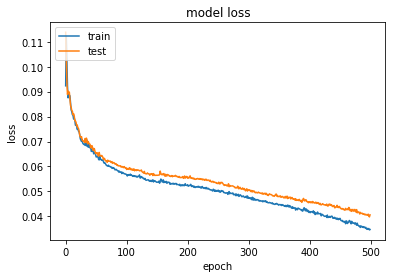

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 5, 2048)           8462336   
_________________________________________________________________
lstm_32 (LSTM)               (None, 5, 512)            5244928   
_________________________________________________________________
lstm_33 (LSTM)               (None, 5, 256)            787456    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 5, 8)              2056      
Total params: 14,496,776
Trainable params: 14,496,776
Non-trainable params: 0
_________________________________________________________________
None
Train on 3298 samples, validate on 825 samples
Epoch 1/500
3298/3298 [==============================] - 7s 2ms/step - loss: 0.1023 - val_loss: 0.1171
Epoch 2/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.1212 - val_loss: 0.1042
Ep

Epoch 70/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0367 - val_loss: 0.0356
Epoch 71/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0367 - val_loss: 0.0359
Epoch 72/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0372 - val_loss: 0.0354
Epoch 73/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0364 - val_loss: 0.0353
Epoch 74/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0367 - val_loss: 0.0352
Epoch 75/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0362 - val_loss: 0.0356
Epoch 76/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0363 - val_loss: 0.0343
Epoch 77/500
3298/3298 [==============================] - 1s 334us/step - loss: 0.0351 - val_loss: 0.0355
Epoch 78/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0364 - val_loss: 0.0352
Epoch 79/500
3298/3298 [======================

Epoch 147/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0335 - val_loss: 0.0325
Epoch 148/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0329 - val_loss: 0.0324
Epoch 149/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0329 - val_loss: 0.0328
Epoch 150/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0333 - val_loss: 0.0329
Epoch 151/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0334 - val_loss: 0.0328
Epoch 152/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0336 - val_loss: 0.0324
Epoch 153/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0326 - val_loss: 0.0331
Epoch 154/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0333 - val_loss: 0.0323
Epoch 155/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0328 - val_loss: 0.0325
Epoch 156/500
3298/3298 [============

Epoch 224/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0309 - val_loss: 0.0311
Epoch 225/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0312 - val_loss: 0.0312
Epoch 226/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0313 - val_loss: 0.0310
Epoch 227/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0311 - val_loss: 0.0312
Epoch 228/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0314 - val_loss: 0.0310
Epoch 229/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0313 - val_loss: 0.0310
Epoch 230/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0312 - val_loss: 0.0314
Epoch 231/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0318 - val_loss: 0.0312
Epoch 232/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0309 - val_loss: 0.0305
Epoch 233/500
3298/3298 [============

Epoch 301/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0294 - val_loss: 0.0294
Epoch 302/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0290 - val_loss: 0.0300
Epoch 303/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0298 - val_loss: 0.0297
Epoch 304/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0292 - val_loss: 0.0296
Epoch 305/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0295 - val_loss: 0.0294
Epoch 306/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0296 - val_loss: 0.0292
Epoch 307/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0291 - val_loss: 0.0298
Epoch 308/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0295 - val_loss: 0.0292
Epoch 309/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0295 - val_loss: 0.0296
Epoch 310/500
3298/3298 [============

Epoch 378/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0274 - val_loss: 0.0281
Epoch 379/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0271 - val_loss: 0.0282
Epoch 380/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0275 - val_loss: 0.0282
Epoch 381/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0273 - val_loss: 0.0282
Epoch 382/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0272 - val_loss: 0.0277
Epoch 383/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0272 - val_loss: 0.0280
Epoch 384/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0269 - val_loss: 0.0283
Epoch 385/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0270 - val_loss: 0.0278
Epoch 386/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0269 - val_loss: 0.0280
Epoch 387/500
3298/3298 [============

Epoch 455/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0253 - val_loss: 0.0268
Epoch 456/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0256 - val_loss: 0.0269
Epoch 457/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0252 - val_loss: 0.0269
Epoch 458/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0254 - val_loss: 0.0267
Epoch 459/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0257 - val_loss: 0.0264
Epoch 460/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0255 - val_loss: 0.0267
Epoch 461/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0253 - val_loss: 0.0267
Epoch 462/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0251 - val_loss: 0.0264
Epoch 463/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0251 - val_loss: 0.0263
Epoch 464/500
3298/3298 [============

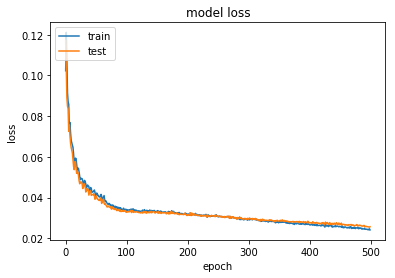

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 5, 2048)           8462336   
_________________________________________________________________
lstm_35 (LSTM)               (None, 5, 512)            5244928   
_________________________________________________________________
lstm_36 (LSTM)               (None, 5, 256)            787456    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 5, 8)              2056      
Total params: 14,496,776
Trainable params: 14,496,776
Non-trainable params: 0
_________________________________________________________________
None
Train on 3298 samples, validate on 825 samples
Epoch 1/500
3298/3298 [==============================] - 8s 2ms/step - loss: 0.0718 - val_loss: 0.1031
Epoch 2/500
3298/3298 [==============================] - 1s 334us/step - loss: 0.1046 - val_loss: 0.0893
Ep

Epoch 70/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0285 - val_loss: 0.0268
Epoch 71/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0285 - val_loss: 0.0266
Epoch 72/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0284 - val_loss: 0.0252
Epoch 73/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0270 - val_loss: 0.0257
Epoch 74/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0277 - val_loss: 0.0258
Epoch 75/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0277 - val_loss: 0.0250
Epoch 76/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0270 - val_loss: 0.0255
Epoch 77/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0271 - val_loss: 0.0252
Epoch 78/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0272 - val_loss: 0.0250
Epoch 79/500
3298/3298 [======================

Epoch 147/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0242 - val_loss: 0.0225
Epoch 148/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0243 - val_loss: 0.0224
Epoch 149/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0237 - val_loss: 0.0224
Epoch 150/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0240 - val_loss: 0.0223
Epoch 151/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0241 - val_loss: 0.0224
Epoch 152/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0245 - val_loss: 0.0221
Epoch 153/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0235 - val_loss: 0.0222
Epoch 154/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0241 - val_loss: 0.0224
Epoch 155/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0243 - val_loss: 0.0226
Epoch 156/500
3298/3298 [============

Epoch 224/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0231 - val_loss: 0.0211
Epoch 225/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0226 - val_loss: 0.0215
Epoch 226/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0229 - val_loss: 0.0213
Epoch 227/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0231 - val_loss: 0.0210
Epoch 228/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0225 - val_loss: 0.0215
Epoch 229/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0228 - val_loss: 0.0214
Epoch 230/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0231 - val_loss: 0.0211
Epoch 231/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0231 - val_loss: 0.0214
Epoch 232/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0228 - val_loss: 0.0213
Epoch 233/500
3298/3298 [============

Epoch 301/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0219 - val_loss: 0.0212
Epoch 302/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0217 - val_loss: 0.0208
Epoch 303/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0219 - val_loss: 0.0205
Epoch 304/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0214 - val_loss: 0.0209
Epoch 305/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0217 - val_loss: 0.0205
Epoch 306/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0218 - val_loss: 0.0207
Epoch 307/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0220 - val_loss: 0.0208
Epoch 308/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0216 - val_loss: 0.0206
Epoch 309/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0213 - val_loss: 0.0208
Epoch 310/500
3298/3298 [============

Epoch 378/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0210 - val_loss: 0.0200
Epoch 379/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0208 - val_loss: 0.0202
Epoch 380/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0207 - val_loss: 0.0205
Epoch 381/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0210 - val_loss: 0.0201
Epoch 382/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0208 - val_loss: 0.0199
Epoch 383/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0205 - val_loss: 0.0201
Epoch 384/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0204 - val_loss: 0.0200
Epoch 385/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0204 - val_loss: 0.0201
Epoch 386/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0206 - val_loss: 0.0203
Epoch 387/500
3298/3298 [============

Epoch 455/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0200 - val_loss: 0.0195
Epoch 456/500
3298/3298 [==============================] - 1s 332us/step - loss: 0.0196 - val_loss: 0.0197
Epoch 457/500
3298/3298 [==============================] - 1s 333us/step - loss: 0.0200 - val_loss: 0.0200
Epoch 458/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0200 - val_loss: 0.0198
Epoch 459/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0201 - val_loss: 0.0200
Epoch 460/500
3298/3298 [==============================] - 1s 331us/step - loss: 0.0205 - val_loss: 0.0202
Epoch 461/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0203 - val_loss: 0.0198
Epoch 462/500
3298/3298 [==============================] - 1s 329us/step - loss: 0.0198 - val_loss: 0.0195
Epoch 463/500
3298/3298 [==============================] - 1s 330us/step - loss: 0.0198 - val_loss: 0.0197
Epoch 464/500
3298/3298 [============

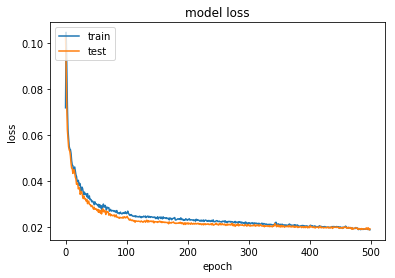

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)

# Train for wind intensity
y_train_wind = np.array([[[features[2],0,0,0,0,0,0,0] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2],0,0,0,0,0,0,0] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0],0,0,0,0,0,0,0] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0],0,0,0,0,0,0,0] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1],0,0,0,0,0,0,0] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1],0,0,0,0,0,0,0] for features in y] for y in y_test], dtype = np.float64)


def bd_lstm_td(X_train, y_train, X_test, y_test) :
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 1024, return_sequences = True, dropout = 0.05), input_shape = (5,8)))
    model.add(LSTM(units = 512, return_sequences = True, dropout = 0.05))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(8)))
    model.compile(loss='mae', optimizer='adam')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = 500,
                        validation_data = (X_test, y_test))
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return model

def lstm_td(X_train, X_test, y_train, y_test) :
    model = Sequential()
    model.add(LSTM(units = 1024, input_shape = (5,8), return_sequences = True))
    model.add(TimeDistributed(Dense(8)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    model.fit(X_train, y_train, batch_size = len(X_train), epochs = 300)
    
    return model

model_wind = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind)
model_lat = bd_lstm_td(X_train, y_train_lat, X_test, y_test_lat)
model_long = bd_lstm_td(X_train, y_train_long, X_test, y_test_long)

Wind


,0
count,4125.000000
mean,-0.420476
std,5.803686
min,-30.584129
25%,-2.923198
50%,-0.005618
75%,2.474480
max,32.698139


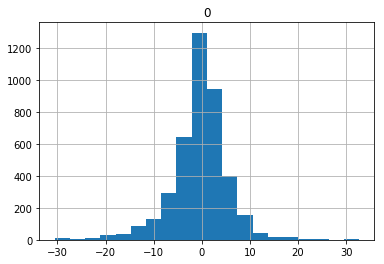

In [34]:
def ai_errors(predictions, observations) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
    OUTPUT:
    '''
    errors = []
    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors
            error = predictions[i][j] - observations[i][j]
            errors.append(error)
            
    # Put into DataFrame for simpler processing
    errors = pd.DataFrame(errors)
    errors.describe()
    errors.hist(bins = 20)
    return errors

# Predict values
wind_predictions = model_wind.predict(X_test)
lat_predictions = model_lat.predict(X_test)
long_predictions = model_long.predict(X_test)

# Scale back our predictions
# Wind
wind_predictions_scaled = [scaler.inverse_transform(prediction) for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform(observation) for observation in y_test_wind]
# Latitude
lat_predictions_scaled = [scaler.inverse_transform(prediction) for prediction in lat_predictions]
y_lat_test_scaled = [scaler.inverse_transform(observation) for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform(prediction) for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform(observation) for observation in y_test_long]

# Record wind predictions and observations
print("Wind")
wind_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]
ai_errors(wind_predictions, wind_observations).describe()

Lat


,0
count,4125.000000
mean,-0.425503
std,3.777579
min,-27.526134
25%,-1.771004
50%,-0.090914
75%,1.340347
max,21.158062


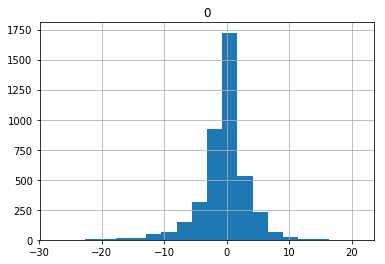

In [35]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
ai_errors(lat_predictions, lat_observations).describe()

Long


,0
count,4125.000000
mean,-0.089128
std,2.883042
min,-17.655134
25%,-1.219658
50%,-0.058225
75%,0.975385
max,18.403868


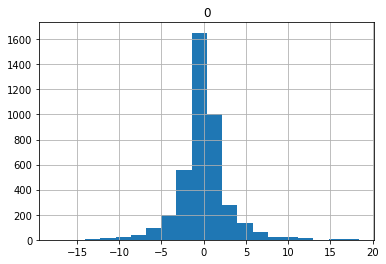

In [36]:
print("Long")
long_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
ai_errors(long_predictions, long_observations).describe()

### All features predicted
count 	5155.000000
mean 	0.163117
std 	8.610414
min 	-84.412697
25% 	-3.376627
50% 	0.507317
75% 	4.218628
max 	44.654633

### Wind features predicted
count 	5155.000000
mean 	-0.737686
std 	3.539089
min 	-37.594856
25% 	-2.207124
50% 	-0.479789
75% 	1.000573
max 	26.066601

### Lat features predicted
count	4125.000000
mean	-0.425503
std	3.777579
min	-27.526134
25%	-1.771004
50%	-0.090914
75%	1.340347
max	21.158062

### Long features predicted
count	4125.000000
mean	-0.089128
std	2.883042
min	-17.655134
25%	-1.219658
50%	-0.058225
75%	0.975385
max	18.403868

In [38]:
index = 400
print(wind_predictions[index], wind_observations[index])
print(lat_predictions[index], lat_observations[index])
print(long_predictions[index], long_observations[index])

[19.061075, 17.145248, 15.932654, 14.621955, 13.18057] [18.4, 18.4, 18.4, 14.8, 14.8]
[42.00122, 35.320225, 33.407787, 34.935413, 37.225067] [45.5, 39.2, 41.2, 41.6, 40.7]
[7.727584, 5.8548985, 4.7140245, 2.5261528, 0.047105026] [9.03936731107206, 6.5592267135325155, 4.1676625659051005, 1.7318101933216212, -0.12829525483303783]
